In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklift.datasets import fetch_hillstrom
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, \
        qini_auc_score, uplift_auc_score
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, \
        plot_uplift_curve

from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

RND = 42            # random state 
TST = 0.3           # % of dataset to reserve for testing
THREADc = 2         # number of parallel threads to use

# 1. Data Wrangling

In [2]:
# load built-in dataset - format: bunch
db = fetch_hillstrom()
print(f"type: {type(db)}\n")

type: <class 'sklearn.utils.Bunch'>



In [3]:
# create dataframe from bunch
df0 = pd.DataFrame(db.data, columns=db.feature_names)
df0["target_" + db.target_name] = pd.Series(db.target)
df0["treatment"] = pd.Series(db.treatment)
df0.tail(4)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,target_visit,treatment
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,0,Mens E-Mail
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,0,Mens E-Mail
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,0,Womens E-Mail
63999,1,4) $350 - $500,472.82,0,1,Surburban,0,Web,0,Mens E-Mail


In [4]:
# any missing values?
df0.isnull().values.any()

False

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   target_visit     64000 non-null  int64  
 9   treatment        64000 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 4.9+ MB


In [6]:
# categorical columns
catcols = list(df0.dtypes[df0.dtypes == object].index)
df0.describe(include='object').T

,count,unique,top,freq
history_segment,64000,7,1) $0 - $100,22970
zip_code,64000,3,Surburban,28776
channel,64000,3,Web,28217
treatment,64000,3,Womens E-Mail,21387


In [7]:
# unique categorical values
set(np.concatenate(df0[catcols].values))

{'1) $0 - $100',
 '2) $100 - $200',
 '3) $200 - $350',
 '4) $350 - $500',
 '5) $500 - $750',
 '6) $750 - $1,000',
 '7) $1,000 +',
 'Mens E-Mail',
 'Multichannel',
 'No E-Mail',
 'Phone',
 'Rural',
 'Surburban',
 'Urban',
 'Web',
 'Womens E-Mail'}

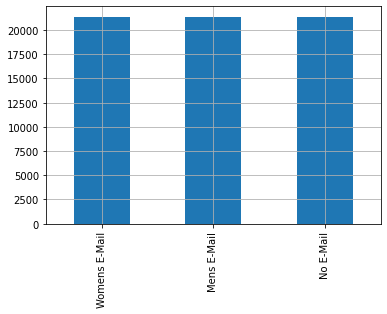

In [8]:
df0.treatment.value_counts().plot(kind="bar", grid=True);

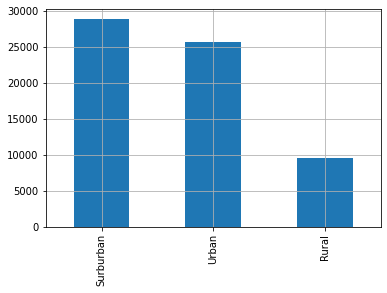

In [9]:
df0.zip_code.value_counts().plot(kind="bar", grid=True);

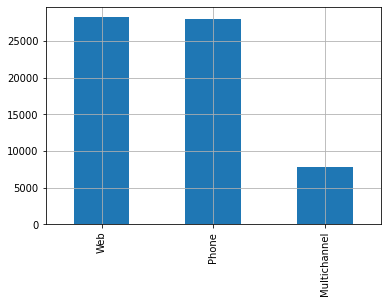

In [10]:
df0.channel.value_counts().plot(kind="bar", grid=True);

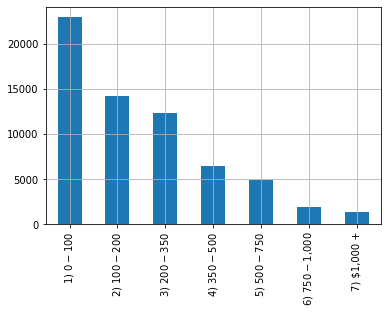

In [11]:
df0.history_segment.value_counts().plot(kind="bar", grid=True);

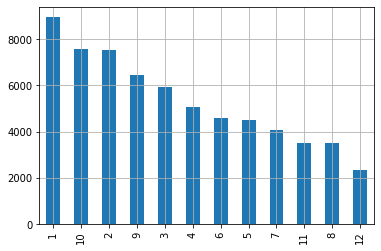

In [12]:
df0.recency.value_counts().plot(kind="bar", grid=True);

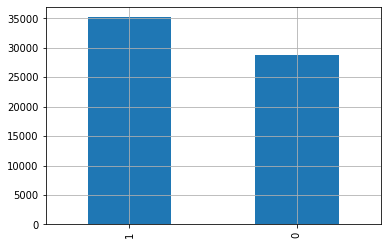

In [13]:
df0.womens.value_counts().plot(kind="bar", grid=True);

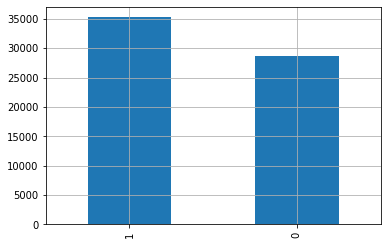

In [14]:
df0.mens.value_counts().plot(kind="bar", grid=True);

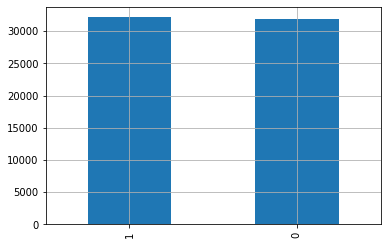

In [15]:
df0.newbie.value_counts().plot(kind="bar", grid=True);

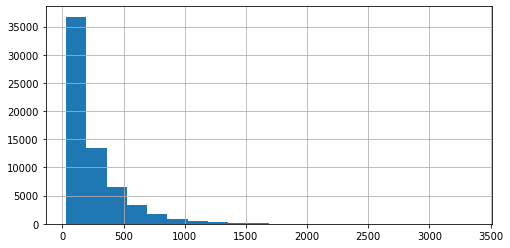

In [16]:
df0.loc[:, "history"].hist(figsize=(8, 4), bins=20, grid=True);

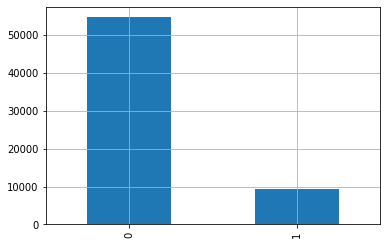

In [17]:
df0.target_visit.value_counts().plot(kind="bar", grid=True);

In [18]:
df0.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'target_visit', 'treatment'],
      dtype='object')

In [19]:
# feature variables X
target, treatment = "target_visit", "treatment"

# list of feature columns: excluding the target columns
features = np.setdiff1d(df0.columns, [target, treatment] ).tolist()
dfX = df0[features]
dfX.tail(4)

,channel,history,history_segment,mens,newbie,recency,womens,zip_code
63996,Phone,38.91,1) $0 - $100,0,1,5,1,Urban
63997,Phone,29.99,1) $0 - $100,1,1,6,0,Urban
63998,Multichannel,552.94,5) $500 - $750,1,1,1,0,Surburban
63999,Web,472.82,4) $350 - $500,0,0,1,1,Surburban


In [20]:
# one-hot encoding: categorical to numerical
dfXn = pd.get_dummies(dfX)
dfXn.tail(4)

,history,mens,newbie,recency,womens,channel_Multichannel,channel_Phone,channel_Web,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban
63996,38.91,0,1,5,1,0,1,0,1,0,0,0,0,0,0,0,0,1
63997,29.99,1,1,6,0,0,1,0,1,0,0,0,0,0,0,0,0,1
63998,552.94,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0
63999,472.82,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0


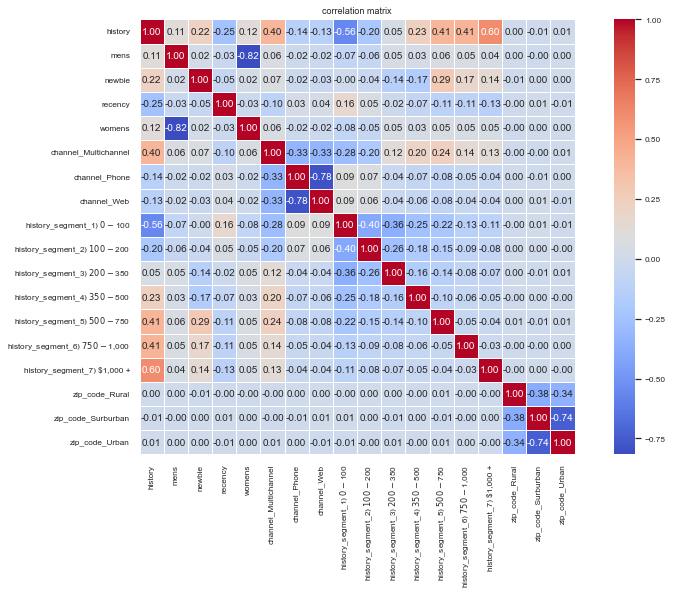

In [21]:
# correlation of features
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(dfXn.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("correlation matrix")
plt.show()

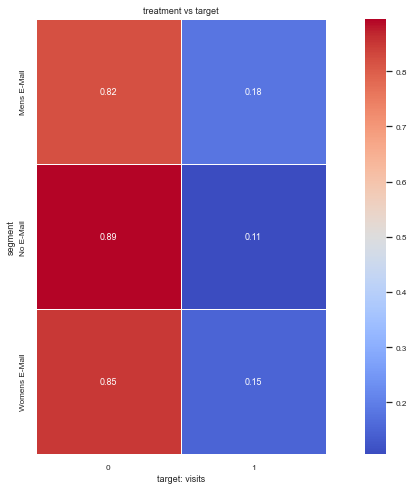

In [22]:
# treatment vs target: visits
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
crosstab = pd.crosstab(db.treatment, db.target, normalize="index")
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = "coolwarm")
plt.xlabel("target: visits")
plt.title("treatment vs target");

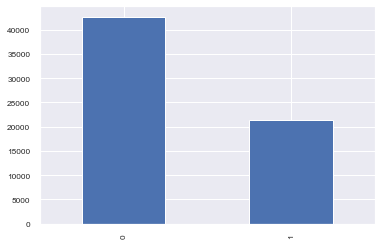

In [23]:
# define Men's E-Mail as treatment = 1, all others as 0
treat = {   "Womens E-Mail": 0,
            "No E-Mail": 0, 
            "Mens E-Mail": 1}
db.treat_men = db.treatment.map(treat)
dfT = pd.concat([db.treat_men, db.target], axis=1)

db.treat_men.value_counts().plot(kind="bar", grid="True");

In [24]:
# train/test split
X_train, X_test, treat_train, treat_test, y_train, y_test = \
        train_test_split(   db.data,
                            db.treat_men,
                            db.target,
                            stratify=dfT,
                            test_size=TST,
                            random_state=RND)

print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (44800, 8)
testing: (19200, 8)


In [25]:
# categorical features
catfeat = list(dfX.select_dtypes(exclude="float").columns)
catfeat = ["womens", "mens", "channel", "zip_code", "history_segment", "newbie"]
catfeat

['womens', 'mens', 'channel', 'zip_code', 'history_segment', 'newbie']

# 3. Models

## 3.1 Class Transformation Model

In [26]:
# class transformation model
ct_estimator = CatBoostClassifier(  verbose = 100, 
                                    cat_features = catfeat,
                                    random_state = RND,
                                    thread_count = THREADc)
model_ct = ClassTransformation(estimator = ct_estimator)
model_ct = model_ct.fit(    X = X_train, 
                            y = y_train, 
                            treatment = treat_train)

Learning rate set to 0.052243
0:	learn: 0.6888651	total: 218ms	remaining: 3m 37s
100:	learn: 0.6506163	total: 5.15s	remaining: 45.9s
200:	learn: 0.6490176	total: 9.68s	remaining: 38.5s
300:	learn: 0.6464764	total: 15.3s	remaining: 35.4s
400:	learn: 0.6438254	total: 20.8s	remaining: 31s
500:	learn: 0.6415029	total: 27.9s	remaining: 27.8s
600:	learn: 0.6392032	total: 34s	remaining: 22.6s
700:	learn: 0.6371060	total: 40.1s	remaining: 17.1s
800:	learn: 0.6348767	total: 45.8s	remaining: 11.4s
900:	learn: 0.6328211	total: 53.6s	remaining: 5.89s
999:	learn: 0.6304796	total: 59.6s	remaining: 0us


In [27]:
# model results: uplift
pred_uplift_ct = model_ct.predict(X_test)
uplift_ct_avg = weighted_average_uplift(y_test, pred_uplift_ct, treat_test, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_ct, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0539


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,640,1280,0.170,0.102,0.069,0.015,0.008,0.017
10-20,629,1291,0.151,0.100,0.051,0.014,0.008,0.017
20-30,633,1287,0.161,0.085,0.076,0.015,0.008,0.017
30-40,636,1284,0.175,0.135,0.040,0.015,0.010,0.018
40-50,628,1292,0.180,0.106,0.074,0.015,0.009,0.018
50-60,667,1253,0.183,0.132,0.050,0.015,0.010,0.018
60-70,667,1253,0.199,0.142,0.057,0.015,0.010,0.018
70-80,621,1299,0.176,0.154,0.022,0.015,0.010,0.018
80-90,657,1263,0.184,0.151,0.033,0.015,0.010,0.018


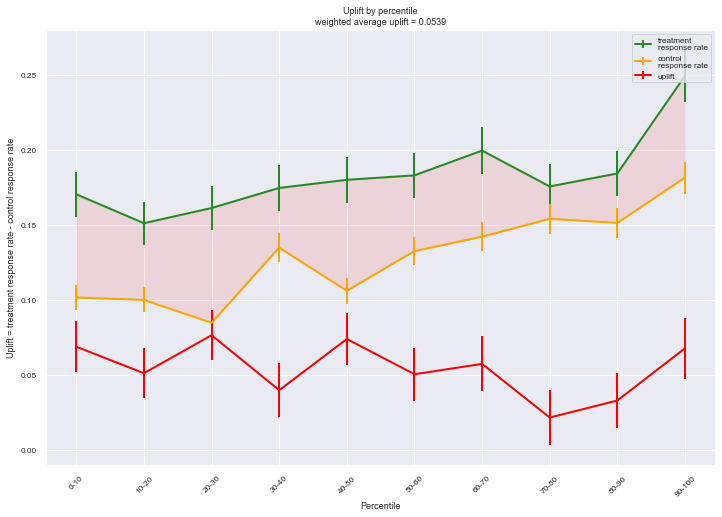

In [28]:
plot_uplift_by_percentile(y_test, pred_uplift_ct, treat_test, strategy="overall", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

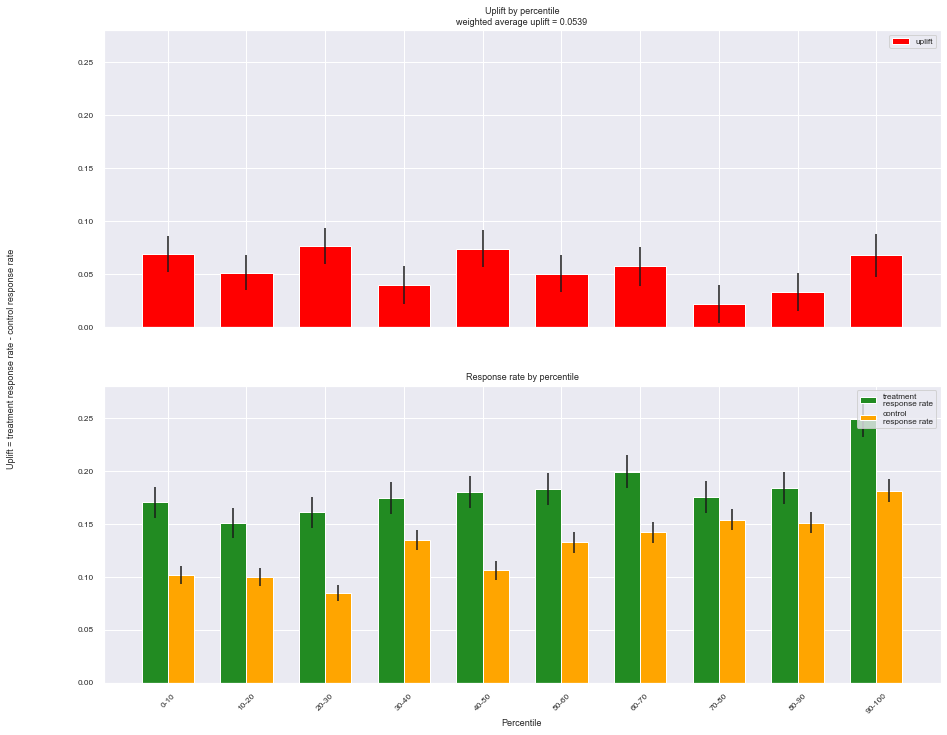

In [29]:
plot_uplift_by_percentile(y_test, pred_uplift_ct, treat_test, strategy="overall", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)

## 3.2 Solo Model

In [30]:
# prepare Solo Model
estimator_sm = CatBoostClassifier(  iterations = 20, 
                                    thread_count = THREADc, 
                                    random_state = RND, 
                                    silent = True)
model_sm = SoloModel(estimator_sm)
model_sm = model_sm.fit(    X = X_train, 
                            y = y_train, 
                            treatment = treat_train, 
                            estimator_fit_params={"cat_features": catfeat})

In [31]:
# model results: uplift
pred_uplift_sm = model_sm.predict(X_test)
uplift_sm_avg = weighted_average_uplift(y_test, pred_uplift_sm, treat_test, bins=10) 
print(f"average uplift: {uplift_sm_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_sm, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0543


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,634,1286,0.260,0.196,0.064,0.017,0.011,0.021
10-20,670,1250,0.215,0.146,0.069,0.016,0.010,0.019
20-30,627,1293,0.185,0.131,0.054,0.016,0.009,0.018
30-40,627,1293,0.199,0.157,0.042,0.016,0.010,0.019
40-50,616,1304,0.190,0.127,0.063,0.016,0.009,0.018
50-60,646,1274,0.166,0.133,0.033,0.015,0.010,0.017
60-70,619,1301,0.179,0.126,0.053,0.015,0.009,0.018
70-80,654,1266,0.144,0.092,0.052,0.014,0.008,0.016
80-90,658,1262,0.128,0.085,0.043,0.013,0.008,0.015


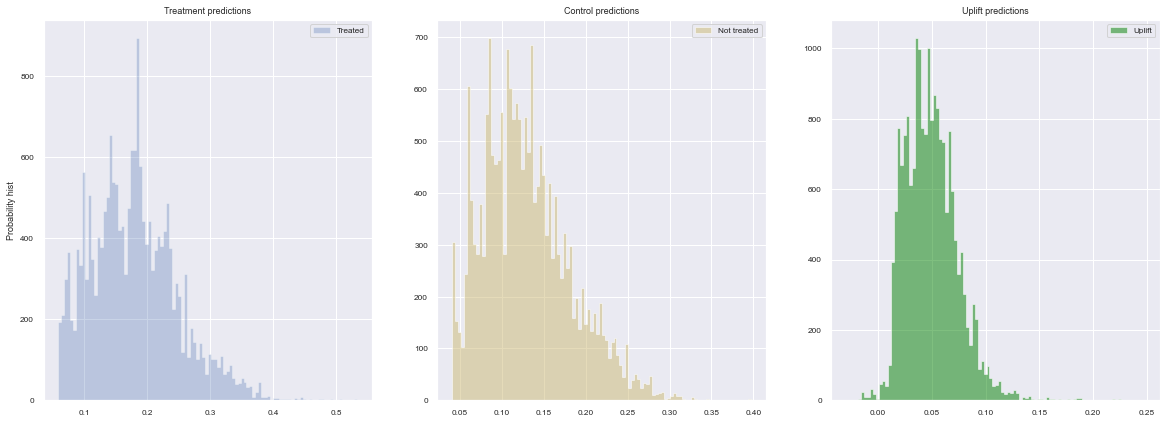

In [32]:
# model results: conditional probabilities of treatment effect
# probability of performing the targeted action (visits):
prob_treat = model_sm.trmnt_preds_         # probability in treatment group
prob_control = model_sm.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

In [33]:
df_imp = pd.DataFrame({
            "feature_name": model_sm.estimator.feature_names_,
            "feature_importance": model_sm.estimator.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,newbie,21.032
1,treatment,13.791
2,womens,13.180
3,history,11.727
4,recency,10.913
5,channel,10.504
6,mens,9.641
7,zip_code,8.803
8,history_segment,0.409


## 3.3 Two Independent Models

In [34]:
# prepare model
estimator_2m_treat = CatBoostClassifier(    iterations = 20, 
                                            thread_count = THREADc, 
                                            random_state = RND, 
                                            silent = True)

estimator_2m_control = CatBoostClassifier(  iterations = 20, 
                                            thread_count = THREADc, 
                                            random_state = RND, 
                                            silent = True)

model_2im = TwoModels(  estimator_trmnt = estimator_2m_treat, 
                        estimator_ctrl = estimator_2m_control, 
                        method = "vanilla")
model_2im = model_2im.fit(  X_train, 
                            y_train, 
                            treat_train,
                            estimator_trmnt_fit_params={"cat_features": catfeat}, 
                            estimator_ctrl_fit_params={"cat_features": catfeat})

In [35]:
# model results: uplift
pred_uplift_2im = model_2im.predict(X_test)
uplift_2im_avg = weighted_average_uplift(y_test, pred_uplift_2im, treat_test, bins=10) 
print(f"average uplift: {uplift_2im_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_2im, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0534


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,653,1267,0.248,0.169,0.079,0.017,0.011,0.020
10-20,629,1291,0.203,0.144,0.059,0.016,0.010,0.019
20-30,637,1283,0.207,0.122,0.085,0.016,0.009,0.018
30-40,651,1269,0.164,0.105,0.060,0.015,0.009,0.017
40-50,632,1288,0.144,0.116,0.028,0.014,0.009,0.017
50-60,662,1258,0.180,0.125,0.055,0.015,0.009,0.018
60-70,615,1305,0.158,0.106,0.052,0.015,0.009,0.017
70-80,594,1326,0.189,0.112,0.076,0.016,0.009,0.018
80-90,663,1257,0.167,0.142,0.025,0.014,0.010,0.018


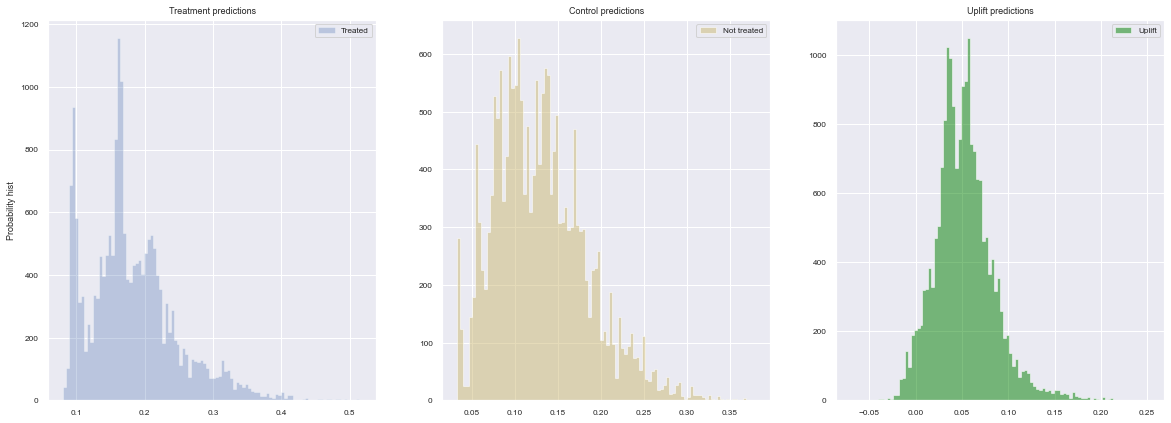

In [36]:
# model results: conditional probabilities of treatment effect
# probability of performing the targeted action (visits):
prob_treat = model_2im.trmnt_preds_         # probability in treatment group
prob_control = model_2im.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

In [37]:
df_imp = pd.DataFrame({
            "feature_name": model_2im.estimator_trmnt.feature_names_,
            "feature_importance": model_2im.estimator_trmnt.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,newbie,28.255
1,womens,15.361
2,mens,14.533
3,recency,14.301
4,history,11.754
5,zip_code,11.030
6,channel,3.935
7,history_segment,0.832


## 3.4 Two Dependent Models: Control Group First

In [38]:
# prepare model
model_2dm = TwoModels(  estimator_trmnt = estimator_2m_treat, 
                        estimator_ctrl = estimator_2m_control, 
                        method = "ddr_control")                    # or: "ddr_treatment"


model_2dm = model_2dm.fit(  X_train, 
                            y_train, 
                            treat_train,
                            estimator_trmnt_fit_params={"cat_features": catfeat}, 
                            estimator_ctrl_fit_params={"cat_features": catfeat})

In [39]:
# model results: uplift
pred_uplift_2dm = model_2dm.predict(X_test)
uplift_2dm_avg = weighted_average_uplift(y_test, pred_uplift_2dm, treat_test, bins=10) 
print(f"average uplift: {uplift_2dm_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_2dm, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0538


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,619,1301,0.263,0.181,0.083,0.018,0.011,0.021
10-20,664,1256,0.193,0.143,0.049,0.015,0.010,0.018
20-30,646,1274,0.206,0.128,0.078,0.016,0.009,0.018
30-40,670,1250,0.175,0.142,0.033,0.015,0.010,0.018
40-50,608,1312,0.183,0.117,0.066,0.016,0.009,0.018
50-60,628,1292,0.175,0.120,0.055,0.015,0.009,0.018
60-70,636,1284,0.165,0.111,0.055,0.015,0.009,0.017
70-80,644,1276,0.166,0.116,0.050,0.015,0.009,0.017
80-90,624,1296,0.133,0.108,0.025,0.014,0.009,0.016


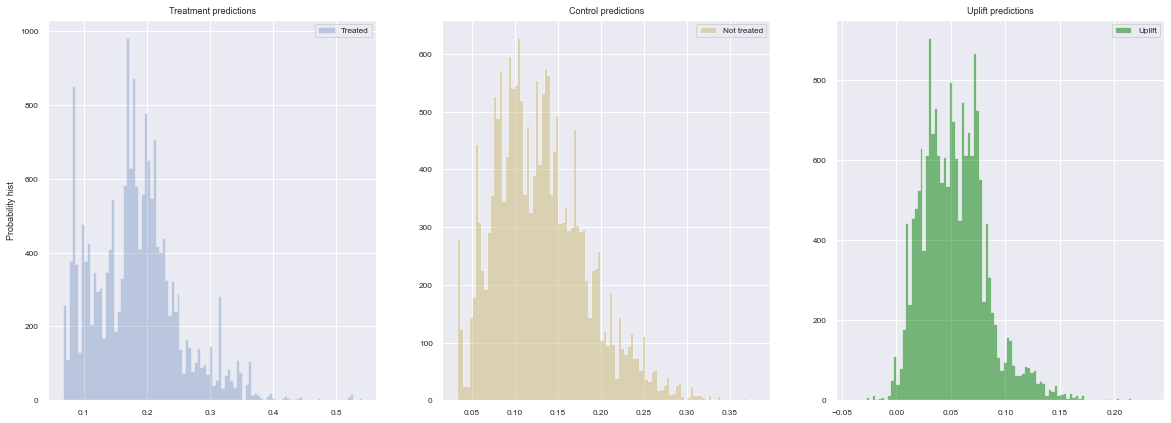

In [40]:
# model results: conditional probabilities of treatment effect
# probability of performing the targeted action (visits):
prob_treat = model_2dm.trmnt_preds_         # probability in treatment group
prob_control = model_2dm.ctrl_preds_        # probability in control group
plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

In [41]:
df_imp = pd.DataFrame({
            "feature_name": model_2dm.estimator_trmnt.feature_names_,
            "feature_importance": model_2dm.estimator_trmnt.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,ddr_control,45.212
1,history,13.284
2,mens,12.918
3,recency,8.907
4,womens,7.391
5,channel,4.824
6,newbie,3.837
7,history_segment,2.508
8,zip_code,1.121


## 3.5 Two Dependent Models: Treatment Group First

In [42]:
# prepare model
model_2dmt = TwoModels(  estimator_trmnt = estimator_2m_treat, 
                         estimator_ctrl = estimator_2m_control, 
                         method = "ddr_treatment")                    


model_2dmt = model_2dmt.fit(  X_train, 
                              y_train, 
                              treat_train,
                              estimator_trmnt_fit_params={"cat_features": catfeat}, 
                              estimator_ctrl_fit_params={"cat_features": catfeat})

In [43]:
# model results: uplift
pred_uplift_2dmt = model_2dmt.predict(X_test)
uplift_2dmt_avg = weighted_average_uplift(y_test, pred_uplift_2dmt, treat_test, bins=10) 
print(f"average uplift: {uplift_2dmt_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_test, 
                        pred_uplift_2dmt, 
                        treat_test, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0533


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,649,1271,0.239,0.173,0.066,0.017,0.011,0.020
10-20,615,1305,0.182,0.114,0.068,0.016,0.009,0.018
20-30,629,1291,0.172,0.120,0.052,0.015,0.009,0.018
30-40,619,1301,0.168,0.119,0.049,0.015,0.009,0.018
40-50,675,1245,0.175,0.131,0.044,0.015,0.010,0.017
50-60,639,1281,0.186,0.101,0.086,0.015,0.008,0.018
60-70,627,1293,0.161,0.122,0.039,0.015,0.009,0.017
70-80,586,1334,0.176,0.120,0.056,0.016,0.009,0.018
80-90,665,1255,0.200,0.156,0.044,0.016,0.010,0.019


In [44]:
df_imp = pd.DataFrame({
            "feature_name": model_2dmt.estimator_trmnt.feature_names_,
            "feature_importance": model_2dmt.estimator_trmnt.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,newbie,28.255
1,womens,15.361
2,mens,14.533
3,recency,14.301
4,history,11.754
5,zip_code,11.030
6,channel,3.935
7,history_segment,0.832


## 3.6 Model Comparison

Class Transformation model:
Qini coefficient: 0.013
Uplift auc score: 0.006


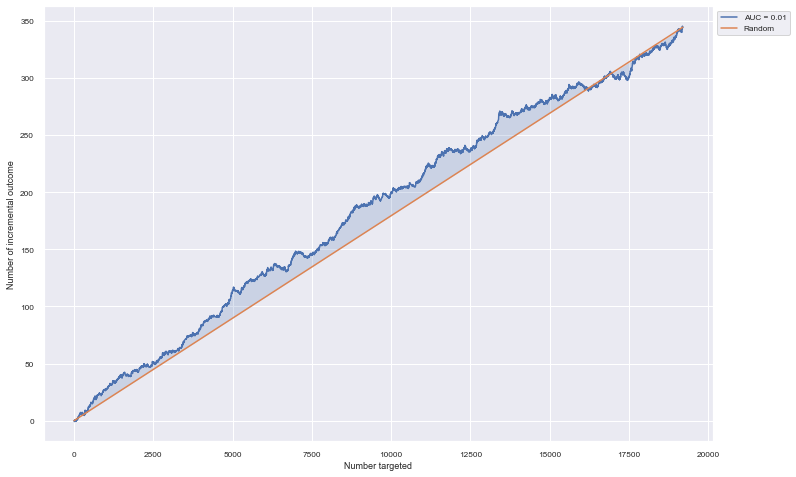

In [45]:
# class transformation
print("Class Transformation model:")

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, pred_uplift_ct, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_test, pred_uplift_ct, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, pred_uplift_ct, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)

Solo model:
Qini coefficient: 0.007
Uplift auc score: 0.004


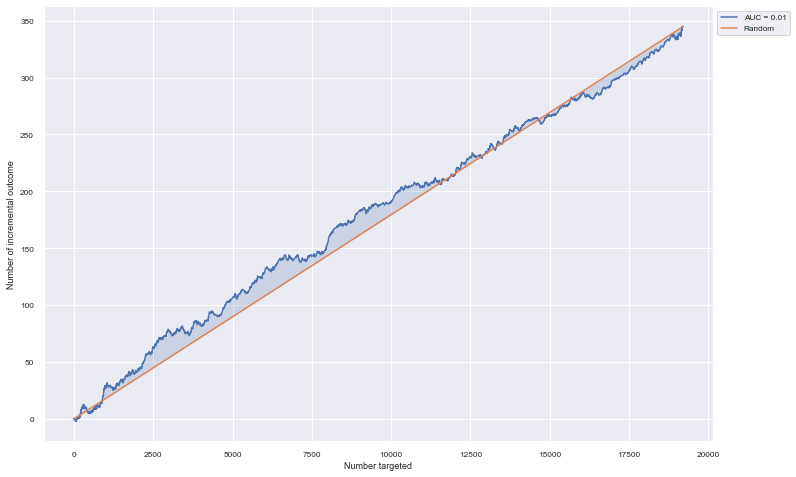

In [46]:
# Solo model
print("Solo model:")

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, pred_uplift_sm, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_test, pred_uplift_sm, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, pred_uplift_sm, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)

2 independent models:
Qini coefficient: 0.030
Uplift auc score: 0.014


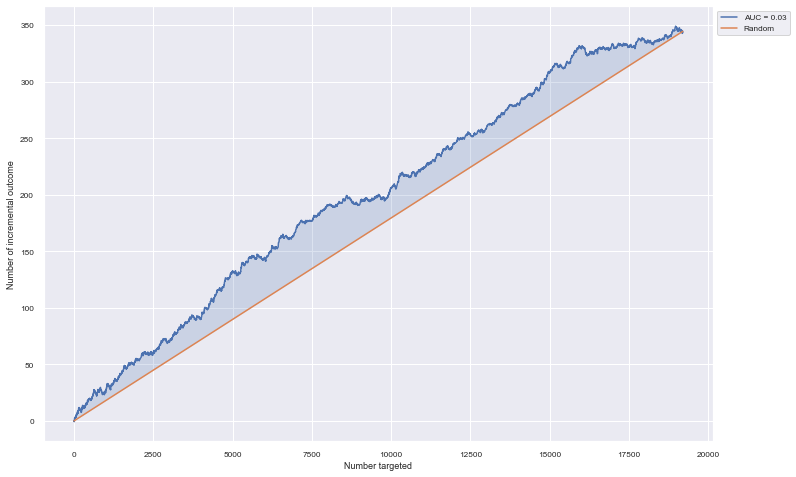

In [47]:
# 2 independent models
print("2 independent models:")

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, pred_uplift_2im, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_test, pred_uplift_2im, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, pred_uplift_2im, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)

2 dependent models: control first:
Qini coefficient: 0.020
Uplift auc score: 0.009


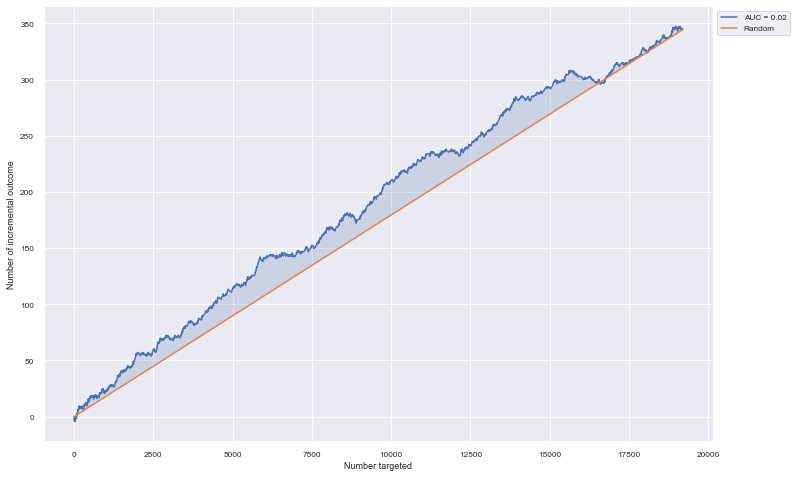

In [48]:
# 2 dependent models: control first
print("2 dependent models: control first:")

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, pred_uplift_2dm, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_test, pred_uplift_2dm, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, pred_uplift_2dm, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)

2 dependent models: treatment first:
Qini coefficient: 0.016
Uplift auc score: 0.008


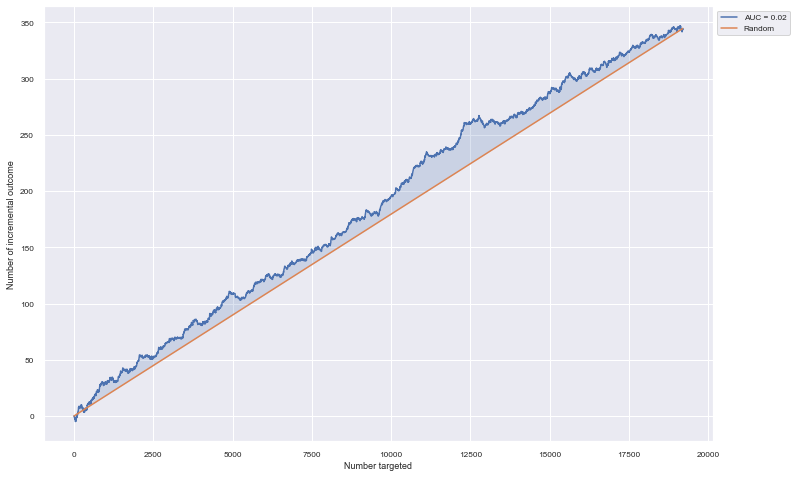

In [49]:
# 2 dependent models: treatment first
print("2 dependent models: treatment first:")

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, pred_uplift_2dmt, treat_test) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_test, pred_uplift_2dmt, treat_test) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_test, pred_uplift_2dmt, treat_test, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)